In [1]:
pip install pytorch-lightning

Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.colab import drive

drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# imports

import glob
import math
import os
import pickle
import random
import tempfile
import time
import urllib
from datetime import datetime, timedelta
from io import StringIO
from typing import List
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pytz
import seaborn as sns
import torch
from pandas.plotting import register_matplotlib_converters
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

register_matplotlib_converters()
%matplotlib inline
sns.set_style("whitegrid")

In [4]:
# load preprocessed data from 10 nodes in the bay area

# df = pd.read_csv("/content/drive/Shareddrives/DATA 298A  B- Electricity Price Prediction/New/processed.csv")
df = pd.read_csv("processed (1).csv")

In [5]:
df.head()

,Unnamed: 0,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,...,HOUR,2DA,7DA,ACTUAL,DAM,ETo (in),Precip (in),Rel Hum (%),Wind Speed (mph),Soil Temp (F)
0,0,2020-01-01T08:00:00-00:00,2020-01-01T08:05:00-00:00,2020-01-01,1,DIXONLD_1_N008,DIXONLD_1_N008,DIXONLD_1_N008,RTM,LMP,...,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
1,1,2020-01-01T08:05:00-00:00,2020-01-01T08:10:00-00:00,2020-01-01,1,DIXONLD_1_N008,DIXONLD_1_N008,DIXONLD_1_N008,RTM,LMP,...,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
2,2,2020-01-01T08:10:00-00:00,2020-01-01T08:15:00-00:00,2020-01-01,1,DIXONLD_1_N008,DIXONLD_1_N008,DIXONLD_1_N008,RTM,LMP,...,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
3,3,2020-01-01T08:15:00-00:00,2020-01-01T08:20:00-00:00,2020-01-01,1,DIXONLD_1_N008,DIXONLD_1_N008,DIXONLD_1_N008,RTM,LMP,...,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
4,4,2020-01-01T08:20:00-00:00,2020-01-01T08:25:00-00:00,2020-01-01,1,DIXONLD_1_N008,DIXONLD_1_N008,DIXONLD_1_N008,RTM,LMP,...,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814


In [6]:
df["NODE"].nunique()

10

In [7]:
df = df.drop(
    [
        "Unnamed: 0",
        "INTERVALENDTIME_GMT",
        "OPR_DT",
        "OPR_HR",
        "NODE_ID_XML",
        "NODE",
        "NODE_ID",
        "MARKET_RUN_ID",
        "LMP_TYPE",
        "XML_DATA_ITEM",
        "PNODE_RESMRID",
        "GRP_TYPE",
    ],
    axis=1,
)

In [8]:
df["INTERVALSTARTTIME_GMT"] = pd.to_datetime(df["INTERVALSTARTTIME_GMT"])

In [9]:
df = df[
    (
        (df["INTERVALSTARTTIME_GMT"].dt.month > 4)
        & (df["INTERVALSTARTTIME_GMT"].dt.month < 10)
    )
]

In [10]:
df["INTERVALSTARTTIME_GMT"].dt.month.unique()

array([5, 6, 7, 8, 9])

In [11]:
df["INTERVALSTARTTIME_GMT"].dt.year.unique()

array([2020, 2021, 2022])

In [12]:
train_set_length = int(round((df.shape[0] * 0.75), 0))
test_set_length = df.shape[0] - train_set_length

print(f"\nTrain: {train_set_length} rows\nTest:  {test_set_length} rows")

train = df.iloc[:train_set_length]
test = df.iloc[train_set_length:]

print(f"\nTrain set shape: {train.shape}\nTest set shape:  {test.shape}\n")


Train: 958392 rows
Test:  319464 rows

Train set shape: (958392, 15)
Test set shape:  (319464, 15)



In [13]:
train = train.set_index("INTERVALSTARTTIME_GMT")
test = test.set_index("INTERVALSTARTTIME_GMT")

In [14]:
features = [col for col in train.columns if col != "VALUE"]
print(len(features))
print(features)

13
['POS', 'OPR_INTERVAL', 'GROUP', 'HOUR', '2DA', '7DA', 'ACTUAL', 'DAM', 'ETo (in)', 'Precip (in)', 'Rel Hum (%)', 'Wind Speed (mph)', 'Soil Temp (F)']


In [15]:
train.head()

,POS,VALUE,OPR_INTERVAL,GROUP,HOUR,2DA,7DA,ACTUAL,DAM,ETo (in),Precip (in),Rel Hum (%),Wind Speed (mph),Soil Temp (F)
INTERVALSTARTTIME_GMT,,,,,,,,,,,,,,
2020-05-01 00:00:00+00:00,1,-0.744149,1,5,8,-3.327543,-2.446943,-3.077697,-2.811133,-3.023405,-0.03305,2.138363,-2.159378,3.209224
2020-05-01 00:05:00+00:00,1,-0.760948,2,5,8,-3.327543,-2.446943,-3.077697,-2.811133,-3.023405,-0.03305,2.138363,-2.159378,3.209224
2020-05-01 00:10:00+00:00,1,-0.753703,3,5,8,-3.327543,-2.446943,-3.077697,-2.811133,-3.023405,-0.03305,2.138363,-2.159378,3.209224
2020-05-01 00:15:00+00:00,1,-0.765075,4,5,8,-3.327543,-2.446943,-3.077697,-2.811133,-3.023405,-0.03305,2.138363,-2.159378,3.209224
2020-05-01 00:20:00+00:00,1,-0.790930,5,5,8,-3.327543,-2.446943,-3.077697,-2.811133,-3.023405,-0.03305,2.138363,-2.159378,3.209224


In [16]:
X_train = train[features]
y_train = train["VALUE"]

X_test = test[features]
y_test = test["VALUE"]

# Classic Machine Learning Models

## Linear Regression

Linear Regression is the most basic regression model.

In [19]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

ValueError: could not convert string to float: 'DIXONLD_1_N008'

In [16]:
prediction = reg.predict(X_test_sc)

NameError: name 'reg' is not defined

In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(y_test, prediction))
print(f"RMSE Score on LinearRegression Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, prediction)
print(f"MAE Score on LinearRegression Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, prediction)
print(f"MAPE Score on LinearRegression Test set: {mape:0.3f}")

NameError: name 'prediction' is not defined

## XGBoost

XGBoost (eXtreme Gradient Boosting) is an open-source software library which provides a regularizing gradient boosting framework. It aims to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library". It runs on a single machine, as well as the distributed processing frameworks Apache Hadoop, Apache Spark, Apache Flink, and Dask.



In [46]:
# Xgboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=10000,
    early_stopping_rounds=50,
    objective="reg:linear",
    max_depth=10,
    learning_rate=0.01,
)
reg.fit(
    X_train_sc,
    y_train,
    eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],
    verbose=100,
)

[00:27:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.21653	validation_1-rmse:1.23416
[100]	validation_0-rmse:1.04097	validation_1-rmse:1.12456
[200]	validation_0-rmse:1.00343	validation_1-rmse:1.11322
[278]	validation_0-rmse:0.99538	validation_1-rmse:1.11310


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [50]:
prediction = reg.predict(X_test_sc)

In [51]:
score = np.sqrt(mse(y_test, prediction))
print(f"RMSE Score on XGBRegressor Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, prediction)
print(f"MAE Score on XGBRegressor Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, prediction)
print(f"MAPE Score on XGBRegressor Test set: {mape:0.3f}")

RMSE Score on XGBRegressor Test set: 1.113
MAE Score on XGBRegressor Test set: 0.437
MAPE Score on XGBRegressor Test set: 3.082


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(y_test, prediction))
print(f"RMSE Score on XGBRegressor Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, prediction)
print(f"MAE Score on XGBRegressor Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, prediction)
print(f"MAPE Score on XGBRegressor Test set: {mape:0.3f}")

RMSE Score on XGBRegressor Test set: 1.113
MAE Score on XGBRegressor Test set: 0.437
MAPE Score on XGBRegressor Test set: 3.082


# Innovative Machine Learning Models

## RNN (LSTM, GRU)

In [17]:
import tensorflow as tf
from keras import regularizers
from keras.layers import GRU, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Time Series Generator Parameters

lookback_length = 12
batch_size = 64

In [ ]:
train_sequences = TimeseriesGenerator(
    X_train, y_train, length=lookback_length, batch_size=batch_size
)
batch_x, batch_y = train_sequences[0]

In [ ]:
test_sequences = TimeseriesGenerator(
    X_test, y_test, length=lookback_length, batch_size=batch_size
)

batch_x_test, batch_y_test = test_sequences[0]

In [ ]:
with tf.device("/gpu:0"):
    model = Sequential()

    model.add(
        GRU(16, input_shape=(batch_x.shape[1], batch_x.shape[2]), return_sequences=True)
    )

    model.add(GRU(16))

    model.add(Dense(32, activation="relu"))
    # model.add(Dropout(0.1))                  # refers to nodes in the first hidden layer

    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.1))

    model.add(Dense(8, activation="relu"))
    # model.add(Dropout(0.1))

    model.add(Dense(1, activation="linear"))

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 16)            1488      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,337
Trainable params: 4,337
Non-trainabl

In [ ]:
# GRU

with tf.device("/gpu:0"):
    model.compile(optimizer=Adam(lr=0.0005), loss="mean_squared_error")

    history = model.fit_generator(
        train_sequences,
        validation_data=test_sequences,
        epochs=1,
        verbose=1,
        use_multiprocessing=True,
    )

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-42-770d6bfa73b1>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


14975/14975 [==============================] - 406s 27ms/step - loss: 1.1765 - val_loss: 1.2882


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred = model.predict(batch_x_test)
score = np.sqrt(mse(pred, batch_y_test))
print(f"RMSE Score on GRU Test set: {score:0.3f}")
mae = mean_absolute_error(pred, batch_y_test)
print(f"MAE Score on GRU Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, batch_y_test)
print(f"MAPE Score on GRU Test set: {mape:0.3f}")

2/2 [==============================] - 1s 12ms/step
RMSE Score on GRU Test set: 0.367
MAE Score on GRU Test set: 0.356
MAPE Score on GRU Test set: 2.792


In [ ]:
# %%LSTM Model
model1 = Sequential()
model1.add(
    LSTM(
        120,
        return_sequences=True,
        input_shape=(batch_x.shape[1], batch_x.shape[2]),
    )
)
model1.add(LSTM(80, return_sequences=True))
model1.add(LSTM(40))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 120)           64320     
                                                                 
 lstm_1 (LSTM)               (None, 12, 80)            64320     
                                                                 
 lstm_2 (LSTM)               (None, 40)                19360     
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 148,041
Trainable params: 148,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# LSTM
model1.compile(optimizer=Adam(lr=0.0005), loss="mean_squared_error")

history1 = model.fit_generator(
    train_sequences, validation_data=test_sequences, epochs=1, verbose=1
)

    1/14975 [..............................] - ETA: 14:52 - loss: 1.6660

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-45-304cf22a4f47>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(


14975/14975 [==============================] - 344s 23ms/step - loss: 1.1631 - val_loss: 1.3209


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred = model.predict(batch_x_test)
score = np.sqrt(mse(pred, batch_y_test))
print(f"RMSE Score on LSTM Test set: {score:0.3f}")
mae = mean_absolute_error(pred, batch_y_test)
print(f"MAE Score on LSTM Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, batch_y_test)
print(f"MAPE Score on LSTM Test set: {mape:0.3f}")

2/2 [==============================] - 0s 11ms/step
RMSE Score on LSTM Test set: 0.281
MAE Score on LSTM Test set: 0.272
MAPE Score on LSTM Test set: 1.211


## Transformer

In [ ]:
# Transformer
from tensorflow import keras
from tensorflow.keras import layers


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
# Attention layer
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
# Train transformer model
input_shape = batch_x.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
# model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    batch_x,
    batch_y,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)
start_time = time.time()
model.evaluate(batch_x_test, batch_y_test, verbose=1)
print(
    "The execution time for Transformer model  %s seconds" % (time.time() - start_time)
)

Epoch 1/200
1/1 [==============================] - 11s 11s/step - loss: 0.8919 - val_loss: 0.9766
Epoch 2/200
1/1 [==============================] - 0s 286ms/step - loss: 0.9240 - val_loss: 0.8833
Epoch 3/200
1/1 [==============================] - 0s 267ms/step - loss: 0.7527 - val_loss: 0.7989
Epoch 4/200
1/1 [==============================] - 0s 278ms/step - loss: 0.6030 - val_loss: 0.7233
Epoch 5/200
1/1 [==============================] - 0s 272ms/step - loss: 0.6425 - val_loss: 0.6532
Epoch 6/200
1/1 [==============================] - 0s 277ms/step - loss: 0.5824 - val_loss: 0.5887
Epoch 7/200
1/1 [==============================] - 0s 292ms/step - loss: 0.5290 - val_loss: 0.5295
Epoch 8/200
1/1 [==============================] - 0s 274ms/step - loss: 0.5291 - val_loss: 0.4761
Epoch 9/200
1/1 [==============================] - 0s 272ms/step - loss: 0.4357 - val_loss: 0.4277
Epoch 10/200
1/1 [==============================] - 0s 295ms/step - loss: 0.4719 - val_loss: 0.3864
Epoch 11/2

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred = model.predict(batch_x_test)
score = np.sqrt(mse(pred, batch_y_test))
print(f"RMSE Score on Transformer Test set: {score:0.3f}")
mae = mean_absolute_error(pred, batch_y_test)
print(f"MAE Score on Transformer Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, batch_y_test)
print(f"MAPE Score on Transformer Test set: {mape:0.3f}")

2/2 [==============================] - 1s 61ms/step
RMSE Score on Transformer Test set: 0.162
MAE Score on Transformer Test set: 0.124
MAPE Score on Transformer Test set: 0.396


## Our Proposed Model

In [82]:
import numpy as np
import torch
import torch.nn as nn


def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc


class PositionalEncodingPermute1D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x) instead of (batchsize, x, ch)
        """
        super(PositionalEncodingPermute1D, self).__init__()
        self.penc = PositionalEncoding1D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 2, 1)

    @property
    def org_channels(self):
        return self.penc.org_channels


class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding2D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 4) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 4d tensor of size (batch_size, x, y, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, ch)
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor has to be 4d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1)
        emb_y = get_emb(sin_inp_y)
        emb = torch.zeros((x, y, self.channels * 2), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, : self.channels] = emb_x
        emb[:, :, self.channels : 2 * self.channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(tensor.shape[0], 1, 1, 1)
        return self.cached_penc


class PositionalEncodingPermute2D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x, y) instead of (batchsize, x, y, ch)
        """
        super(PositionalEncodingPermute2D, self).__init__()
        self.penc = PositionalEncoding2D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 3, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 3, 1, 2)

    @property
    def org_channels(self):
        return self.penc.org_channels


class PositionalEncoding3D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding3D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 6) * 2)
        if channels % 2:
            channels += 1
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 5d tensor of size (batch_size, x, y, z, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, z, ch)
        """
        if len(tensor.shape) != 5:
            raise RuntimeError("The input tensor has to be 5d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, z, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        pos_z = torch.arange(z, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        sin_inp_z = torch.einsum("i,j->ij", pos_z, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1).unsqueeze(1)
        emb_y = get_emb(sin_inp_y).unsqueeze(1)
        emb_z = get_emb(sin_inp_z)
        emb = torch.zeros((x, y, z, self.channels * 3), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, :, : self.channels] = emb_x
        emb[:, :, :, self.channels : 2 * self.channels] = emb_y
        emb[:, :, :, 2 * self.channels :] = emb_z

        self.cached_penc = emb[None, :, :, :, :orig_ch].repeat(batch_size, 1, 1, 1, 1)
        return self.cached_penc


class PositionalEncodingPermute3D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x, y, z) instead of (batchsize, x, y, z, ch)
        """
        super(PositionalEncodingPermute3D, self).__init__()
        self.penc = PositionalEncoding3D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 3, 4, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 4, 1, 2, 3)

    @property
    def org_channels(self):
        return self.penc.org_channels


class Summer(nn.Module):
    def __init__(self, penc):
        """
        :param model: The type of positional encoding to run the summer on.
        """
        super(Summer, self).__init__()
        self.penc = penc

    def forward(self, tensor):
        """
        :param tensor: A 3, 4 or 5d tensor that matches the model output size
        :return: Positional Encoding Matrix summed to the original tensor
        """
        penc = self.penc(tensor)
        assert (
            tensor.size() == penc.size()
        ), "The original tensor size {} and the positional encoding tensor size {} must match!".format(
            tensor.size(), penc.size()
        )
        return tensor + penc

In [193]:
# dense -> MLP             -\
# sparse -> nn.Embedding   --  MLP

from torch import Tensor


class ElectricyMarketPriceModule(pl.LightningModule):
    def __init__(self):
        super().__init__()

        embedding_dim = 128
        self._dense_mlp = nn.Sequential(
            nn.LazyLinear(16),
            nn.Tanh(),
        )
        self._month_emb = nn.Embedding(12, embedding_dim)
        self._hour_emb = nn.Embedding(24, embedding_dim)
        self._weekday_emb = nn.Embedding(7, embedding_dim)
        self._node_emb = nn.Embedding(10, embedding_dim)
        self._sparse_mlp = nn.Sequential(
            nn.LazyLinear(128),
            nn.Tanh(),
        )
        self.pos_encoder = Summer(PositionalEncoding1D(16 + 128))
        self._encoder_layer = nn.TransformerEncoderLayer(d_model=16 + 128, nhead=4)
        self._transformer_encoder = nn.TransformerEncoder(
            self._encoder_layer, num_layers=2
        )
        self._over_mlp = nn.Sequential(
            nn.LazyLinear(64),
            nn.Tanh(),
            nn.LazyLinear(6),
        )

        self.loss = nn.MSELoss()

    def training_step(self, batch):
        dense, sparse, label = batch
        # print(f"dense = {dense}")
        # print(f"sparse = {sparse}")
        # print(f"label = {label}")
        # raise Exception()

        B = dense.size(0)
        dense_out = self._dense_mlp(dense)
        month_embs = self._month_emb(sparse[:, :, 0])
        hour_embs = self._hour_emb(sparse[:, :, 1])
        weekday_embs = self._weekday_emb(sparse[:, :, 2])
        node_embs = self._node_emb(sparse[:, :, 3])
        sparse_out = self._sparse_mlp(
            torch.cat([month_embs, hour_embs, weekday_embs, node_embs], dim=-1)
        )
        attn_input = self.pos_encoder(torch.cat([dense_out, sparse_out], dim=-1))
        # attn_input = self.pos_encoder(dense_out)
        attn_output = self._transformer_encoder(attn_input)  # [B, 288, 68]
        pred = self._over_mlp(attn_output.view(B, -1))
        # print(f'pred {pred}')
        # print(f'label {label}')
        loss = self.loss(pred, label)
        # print(f'loss {loss}')
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.cnn_net(x)
        out = out.view(x.size(0), -1)
        pred = self.linear_net(out)
        pred = torch.argmax(pred, dim=1)
        self.log("val_loss", (pred == y).sum().item() / x.size(0), prog_bar=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.cnn_net(x)
        out = out.view(x.size(0), -1)
        pred = self.linear_net(out)
        pred = torch.argmax(pred, dim=1)
        self.log("test_loss", (pred == y).sum().item() / x.size(0))

    def predict_step(self, batch, batch_idx):
        dense, sparse, label = batch
        # print(f"dense = {dense}")
        # print(f"sparse = {sparse}")
        # print(f"label = {label}")
        # raise Exception()

        B = dense.size(0)
        dense_out = self._dense_mlp(dense)
        month_embs = self._month_emb(sparse[:, :, 0])
        hour_embs = self._hour_emb(sparse[:, :, 1])
        weekday_embs = self._weekday_emb(sparse[:, :, 2])
        node_embs = self._node_emb(sparse[:, :, 3])
        sparse_out = self._sparse_mlp(
            torch.cat([month_embs, hour_embs, weekday_embs, node_embs], dim=-1)
        )
        attn_input = self.pos_encoder(torch.cat([dense_out, sparse_out], dim=-1))
        attn_output = self._transformer_encoder(attn_input)  # [B, 288, 68]
        pred = self._over_mlp(attn_output.view(B, -1))
        return pred, label

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer, gamma=0.95, verbose=True
        )
        return [optimizer], [lr_scheduler]

In [80]:
import dateutil

node_to_id = {}


class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, df, years: List[int]):
        super(MyIterableDataset).__init__()

        self._df = df

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        assert (
            worker_info is None
        )  # single-process data loading, return the full iterator

        price_list: List[float] = []
        dense_list: List[List[float]] = []
        month_list: List[int] = []
        hour_list: List[int] = []
        weekday_list: List[int] = []
        node_list: List[int] = []

        for index, row in self._df.iterrows():
            # 24 hours for training, 1 hour for ground truth
            if len(price_list) == 24 * 12 + 12 * 24:
                indices = list(range(0, 24 * 12, 12))
                yield torch.tensor(
                    [dense_list[i] for i in indices], dtype=torch.float
                ), torch.tensor(
                    list(
                        zip(
                            [month_list[i] for i in indices],
                            [hour_list[i] for i in indices],
                            [weekday_list[i] for i in indices],
                            [node_list[i] for i in indices],
                        )
                    ),
                    dtype=torch.int,
                ), torch.tensor(
                    [
                        price_list[24 * 12],
                        price_list[24 * 12 + 11],
                        price_list[24 * 12 + 12 * 2 - 1],
                        price_list[24 * 12 + 12 * 4 - 1],
                        price_list[24 * 12 + 12 * 12 - 1],
                        price_list[24 * 12 + 12 * 24 - 1],
                    ],
                    dtype=torch.float,
                ),

                # 5 minutes, one hour, 2 hours, 4 hours, 12 hours, 24 hours

                price_list.pop(0)
                dense_list.pop(0)
                month_list.pop(0)
                hour_list.pop(0)
                weekday_list.pop(0)
                node_list.pop(0)

            price_list.append(float(row["VALUE"]))
            dense_list.append([float(row["VALUE"])] + row[df.columns[-9:]].tolist())
            curt_dt = row["INTERVALSTARTTIME_GMT"].to_pydatetime() + timedelta(hours=8)
            month_list.append(curt_dt.month - 1)
            hour_list.append(curt_dt.hour)
            weekday_list.append(curt_dt.weekday())
            if row["NODE_ID"] not in node_to_id:
                node_to_id[row["NODE_ID"]] = len(node_to_id)
            node_list.append(node_to_id[row["NODE_ID"]])


train_dataset = MyIterableDataset(df, years=[2020, 2021])
test_dataset = MyIterableDataset(df, years=[2022])

In [81]:
class ShuffleDataset(torch.utils.data.IterableDataset):
    def __init__(self, dataset, buffer_size):
        super().__init__()
        self.dataset = dataset
        self.buffer = list(iter(self.dataset))

    def __iter__(self):
        buffer = self.buffer
        random.shuffle(buffer)
        buffer_iter = iter(buffer)

        try:
            while True:
                try:
                    yield next(buffer_iter)
                except StopIteration:
                    break
        except GeneratorExit:
            pass


shuffled_train_dataset = ShuffleDataset(train_dataset, 12 * 24 * 7 * 30 * 12)
shuffled_test_dataset = ShuffleDataset(test_dataset, 12 * 24 * 7 * 30 * 12)

In [194]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        print(f"linear {m}")
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Embedding):
        print(f"embedding {m}")
        nn.init.uniform_(m.weight, -1.0, 1.0)


module = ElectricyMarketPriceModule()

batch = next(iter(DataLoader(train_dataset, batch_size=32)))
module.training_step(batch)
module.apply(init_weights)
module.training_step(batch)

/home/zyan/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


linear Linear(in_features=10, out_features=16, bias=True)
embedding Embedding(12, 128)
embedding Embedding(24, 128)
embedding Embedding(7, 128)
embedding Embedding(10, 128)
linear Linear(in_features=512, out_features=128, bias=True)
linear NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
linear Linear(in_features=144, out_features=2048, bias=True)
linear Linear(in_features=2048, out_features=144, bias=True)
linear NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
linear Linear(in_features=144, out_features=2048, bias=True)
linear Linear(in_features=2048, out_features=144, bias=True)
linear NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
linear Linear(in_features=144, out_features=2048, bias=True)
linear Linear(in_features=2048, out_features=144, bias=True)
linear Linear(in_features=3456, out_features=64, bias=True)
linear Linear(in_features=64, out_features=6, bias=True)


/home/zyan/miniconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/tmp/ipykernel_34292/1710434713.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


tensor(1.4258, grad_fn=<MseLossBackward0>)

In [190]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")
trainer = pl.Trainer(
    max_epochs=2,
    callbacks=[lr_monitor],
    logger=TensorBoardLogger("tb_logs", name="my_model"),
    accelerator="gpu",  # accelerator="gpu",
)
trainer.fit(module, DataLoader(shuffled_train_dataset, batch_size=1024))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zyan/miniconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                 | Type                    | Params
------------------------------------------------------------------
0  | _dense_mlp           | Sequential              | 1.4 K 
1  | _month_

Adjusting learning rate of group 0 to 1.0000e-02.


/home/zyan/miniconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5000e-03.


`Trainer.fit` stopped: `max_epochs=2` reached.


Adjusting learning rate of group 0 to 9.0250e-03.


In [191]:
res = trainer.predict(module, DataLoader(shuffled_test_dataset, batch_size=1024))

You are using a CUDA device ('NVIDIA Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zyan/miniconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [192]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

mses = []
maes = []
mapes = []

start, end = 0, 1

for r in res:
    pred, test = r
    mses.append(np.sqrt(mse(pred[:, start:end], test[:, start:end])))
    maes.append(mean_absolute_error(pred[:, start:end], test[:, start:end]))
    mapes.append(mean_absolute_percentage_error(pred[:, start:end], test[:, start:end]))

print(f"RMSE Score on Transformer Test set: {sum(mses)/len(mses):0.3f}")
print(f"MAE Score on Transformer Test set: {sum(maes)/len(maes):0.3f}")
print(f"MAPE Score on Transformer Test set: {sum(mapes)/len(mapes):0.3f}")

mses.sort()
maes.sort()
mapes.sort()

print(f"RMSE Score on Transformer Test set: {mses[len(mses)//2]:0.3f}")
print(f"MAE Score on Transformer Test set: {maes[len(maes)//2]:0.3f}")
print(f"MAPE Score on Transformer Test set: {mapes[len(mapes)//2]:0.3f}")

RMSE Score on Transformer Test set: 0.915
MAE Score on Transformer Test set: 0.397
MAPE Score on Transformer Test set: 13.683
RMSE Score on Transformer Test set: 0.901
MAE Score on Transformer Test set: 0.396
MAPE Score on Transformer Test set: 8.336


In [174]:
RMSE Score on Transformer Test set: 0.580
MAE Score on Transformer Test set: 0.197
MAPE Score on Transformer Test set: 2.371

SyntaxError: invalid syntax (4036929209.py, line 1)

## Trading

In [ ]:
# baseline: buy at at 9pm - 9am, sell at 9am - 9pm

balance = 0.0
charged = 0.0
naive_dts = []
naive_balances = []
naive_remainings = []

CAPACITY = 13.3
CHARGE_SPEED = 3.3

price_list: List[float] = []
month_list: List[int] = []
hour_list: List[int] = []
weekday_list: List[int] = []


pbar = tqdm(df.iterrows())
for index, row in pbar:
    price = float(row["VALUE"])
    price_list.append(float(row["VALUE"]))
    curt_dt = datetime.strptime(
        row["INTERVALSTARTTIME_GMT"], "%Y-%m-%dT%H:%M:00-00:00"
    ) + timedelta(hours=8)
    month_list.append(curt_dt.month - 1)
    hour_list.append(curt_dt.hour)
    weekday_list.append(curt_dt.weekday())

    if curt_dt.year != 2022:
        if curt_dt.hour == 0:
            pbar.set_description(f"{curt_dt}")
        continue

    # trade at minute 0
    if curt_dt.minute == 0:
        naive_dts.append(curt_dt)
        naive_balances.append(balance)
        naive_remainings.append(charged)

        if curt_dt.hour >= 9 and curt_dt.hour < 21:
            if charged > 0:
                balance += price * (CAPACITY / 12)
                charged -= CAPACITY / 12
        else:
            if charged < CAPACITY:
                balance -= price * (CAPACITY / 12)
                charged += CAPACITY / 12

        if curt_dt.hour == 0:
            pbar.set_description(f"{curt_dt} {balance}")

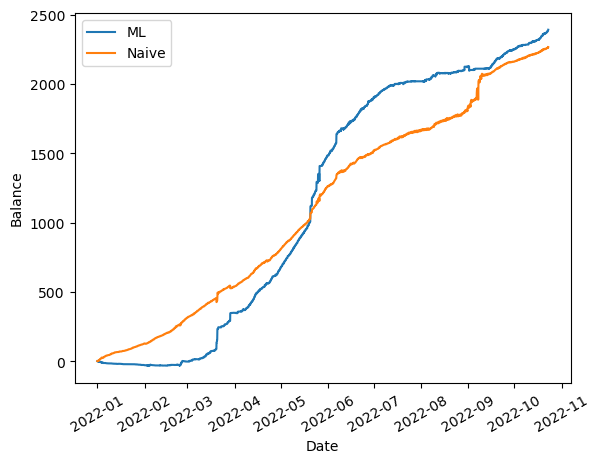

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dts, balances, label="ML")
plt.plot(naive_dts, naive_balances, label="Naive")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Balance")
plt.legend()
plt.show()

## Reinforcement Learning

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gym import spaces


class TimeSeriesForecastingEnv(gym.Env):
    def __init__(self, dataset, window_size, categorical_columns, numerical_columns):
        super(TimeSeriesForecastingEnv, self).__init__()

        self.dataset = dataset
        self.window_size = window_size
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns
        self.current_step = 0

        self.action_space = spaces.Discrete(3)  # Buy, hold, sell
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(window_size, len(categorical_columns + numerical_columns)),
            dtype=np.float32,
        )

    def _get_observation(self):
        return self.dataset[self.current_step : self.current_step + self.window_size]

    def step(self, action):
        self.current_step += 1

        observation = self._get_observation()
        done = self.current_step >= len(self.dataset) - self.window_size
        reward = 0  # Replace this with a suitable reward function for your problem

        return observation, reward, done, {}

    def reset(self):
        self.current_step = 0
        return self._get_observation()

In [2]:
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Load and preprocess your dataset
data = pd.read_csv("your_dataset.csv")
categorical_columns = ["cat_col1", "cat_col2"]
numerical_columns = ["num_col1", "num_col2"]
window_size = 10

# Preprocess your data (normalize, encode categorical variables, etc.)
# ...

env = TimeSeriesForecastingEnv(
    data, window_size, categorical_columns, numerical_columns
)
env = DummyVecEnv([lambda: env])  # PPO requires a vectorized environment

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

FileNotFoundError: [Errno 2] No such file or directory: 'your_dataset.csv'

In [3]:
def predict(model, data, window_size):
    predictions = []

    for i in range(len(data) - window_size):
        obs = data[i : i + window_size]
        action, _ = model.predict(obs, deterministic=True)
        predictions.append(action)

    return predictions


predictions = predict(model, data, window_size)

NameError: name 'model' is not defined